# Test models and BLAST for evidence-based promiscuous enzymes

In [ ]:
# define the directory where the data is
data_path = "/home/joao/Desktop/required_data_ec_number_paper/"

In [6]:
from plants_sm.data_structures.dataset.single_input_dataset import SingleInputDataset

evidence_dataset = SingleInputDataset.from_csv(f'{data_path}/data/test_promiscous_evidence.csv',
                                            instances_ids_field="accession", representation_field="sequence", labels_field=slice(8, 2779))

In [7]:
y_true = evidence_dataset.y

In [8]:
def get_labels_to_remove(dataset, labels_names):
    labels_with_no_positive_sample = []
    for i, label in enumerate(labels_names):
        if dataset[label].sum() == 0:
            labels_with_no_positive_sample.append(i)
    return labels_with_no_positive_sample

In [9]:
import pandas as pd


dataset = pd.read_csv(f'{data_path}/data/test_promiscous_evidence.csv')
labels = evidence_dataset._labels_names
labels_to_remove = get_labels_to_remove(dataset, labels)
len(labels_to_remove)

2235

In [10]:
len(labels)

2771

In [11]:
import re

def get_ec_levels(labels):
    level_1 = []
    level_2 = []
    level_3 = []
    level_4 = []
    for i, label in enumerate(labels):
        if re.match(r"^\d+.\d+.\d+.n*\d+$", label):
            level_4.append(i)
        elif re.match(r"^\d+.\d+.\d+$", label):
            level_3.append(i)
        elif re.match(r"^\d+.\d+$", label):
            level_2.append(i)
        elif re.match(r"^\d+$", label):
            level_1.append(i)
    return level_1, level_2, level_3, level_4

In [12]:
import numpy as np
y_true_ = np.delete(y_true, labels_to_remove, axis=1)
labels_ = np.delete(labels, labels_to_remove)
level_1, level_2, level_3, level_4 = get_ec_levels(labels_)

## Check the distribution of labels for each level

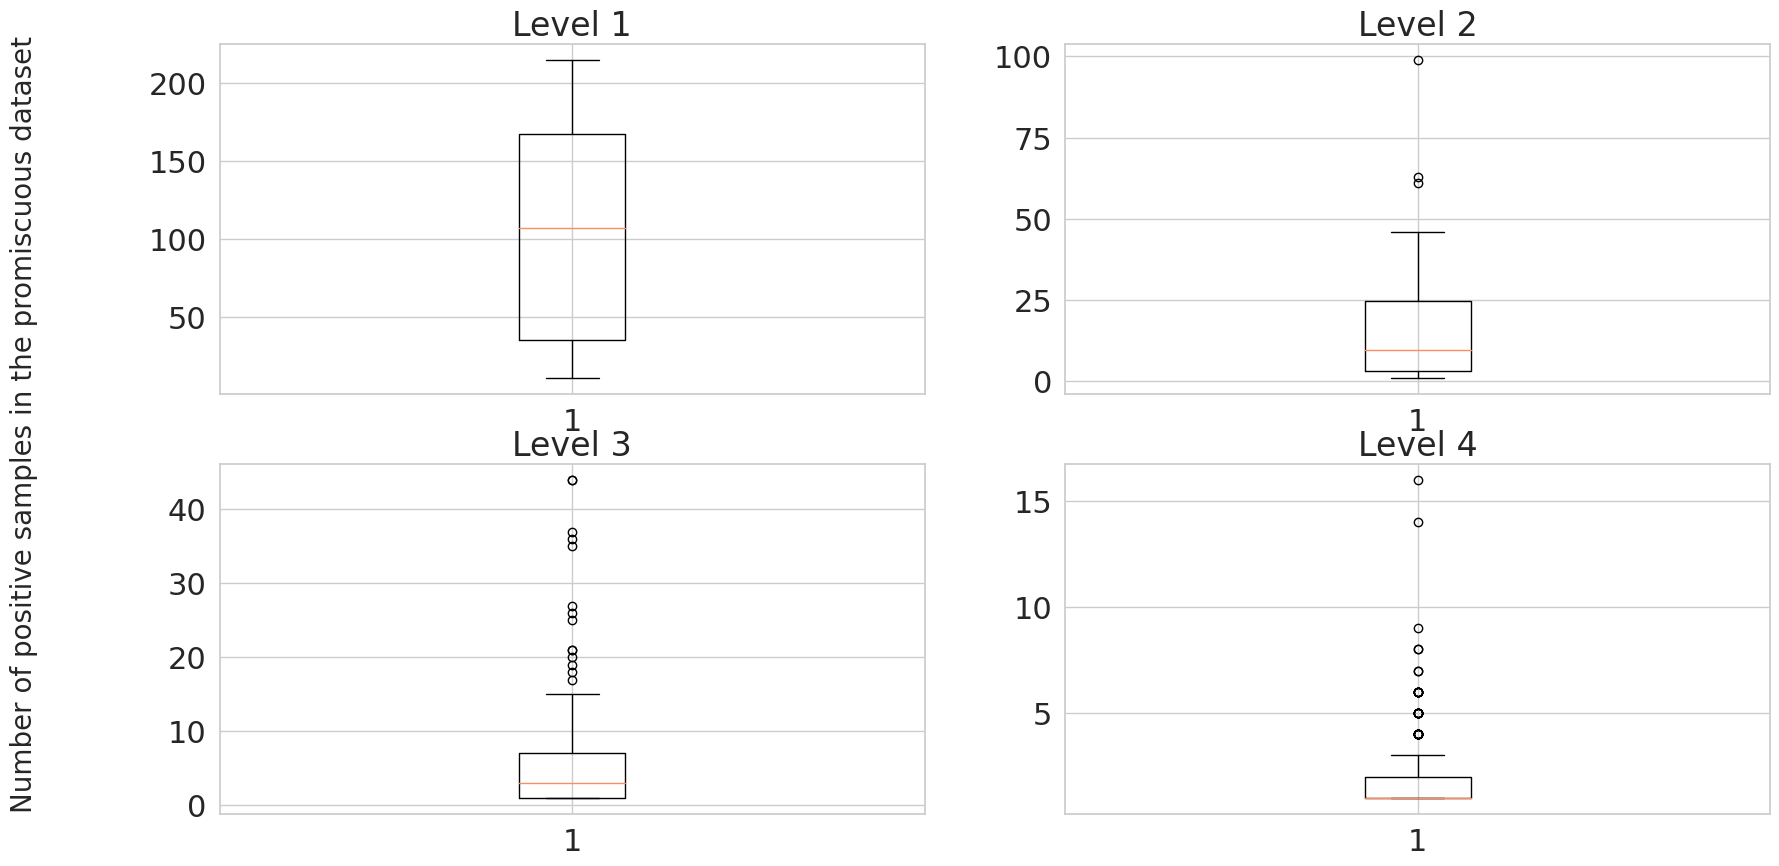

In [13]:
# get distribution of labels for level 4
import numpy as np

# remove all 0 values and create boxplot for level 4
y_true_level_4 = y_true_[:, level_4]
y_true_level_4 = y_true_level_4[y_true_level_4.sum(axis=1) != 0]
distribution_level4 = y_true_level_4.sum(axis=0)

y_true_level_3 = y_true_[:, level_3]
y_true_level_3 = y_true_level_3[y_true_level_3.sum(axis=1) != 0]
distribution_level3 = y_true_level_3.sum(axis=0)

y_true_level_2 = y_true_[:, level_2]
y_true_level_2 = y_true_level_2[y_true_level_2.sum(axis=1) != 0]
distribution_level2 = y_true_level_2.sum(axis=0)

y_true_level_1 = y_true_[:, level_1]
y_true_level_1 = y_true_level_1[y_true_level_1.sum(axis=1) != 0]
distribution_level1 = y_true_level_1.sum(axis=0)

# make 4 plots instead of only one
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.boxplot(distribution_level1)
fig.supylabel('Number of positive samples in the promiscuous dataset', fontsize=20)
# plt.ylabel('Number of positive samples in the evidence-level dataset')
plt.title('Level 1')
plt.subplot(2, 2, 2)
plt.boxplot(distribution_level2)
plt.title('Level 2')
plt.subplot(2, 2, 3)
plt.boxplot(distribution_level3)
plt.title('Level 3')
plt.subplot(2, 2, 4)
plt.boxplot(distribution_level4)
plt.title('Level 4')
plt.show()


In [5]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def get_metrics(y_true, predictions, labels, labels_to_remove, model_name):
    y_true_ = np.delete(y_true, labels_to_remove, axis=1)
    predictions_ = np.delete(predictions, labels_to_remove, axis=1)
    labels_ = np.delete(labels, labels_to_remove)
    level_1, level_2, level_3, level_4 = get_ec_levels(labels_)

    type_ = "weighted"
    
    metrics = {}
    metrics["wF1"] = f1_score(y_true_, predictions_, average=type_)
    metrics["wF1 level 1"] = f1_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wF1 level 2"] = f1_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wF1 level 3"] = f1_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wF1 level 4"] = f1_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)

    metrics["wPrecision"] = precision_score(y_true_, predictions_, average=type_)
    metrics["wPrecision level 1"] = precision_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wPrecision level 2"] = precision_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wPrecision level 3"] = precision_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wPrecision level 4"] = precision_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)

    metrics["wRecall"] = recall_score(y_true_, predictions_, average=type_)
    metrics["wRecall level 1"] = recall_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wRecall level 2"] = recall_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wRecall level 3"] = recall_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wRecall level 4"] = recall_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)
    return pd.DataFrame(metrics, index=[model_name])

def get_models_predictions(model, dataset, labels, labels_to_remove, model_name):
    predictions = model.predict(dataset)
    y_true = dataset.y

    return get_metrics(y_true, predictions, labels, labels_to_remove, model_name)

# ESM2 3B

In [47]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load(f'{data_path}/DNN_esm2_t36_3B_UR50D_trial_2_merged')
evidence_dataset.load_features(f"{data_path}/features/test_esm2_3b")

In [48]:
model.device = "cuda:0"

In [49]:
models_performance = get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ESM2 3B")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# ESM1b

In [51]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load(f'{data_path}/models/DNN_esm1b_t33_650M_UR50S_trial_4_merged')
evidence_dataset.load_features(f"{data_path}/features/test_esm1b")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ESM1b")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# ProtBERT

In [52]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load(f'{data_path}/models/DNN_prot_bert_vectors_trial_2_merged')
evidence_dataset.load_features(f"{data_path}/features/test_prot_bert")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ProtBERT")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

In [53]:
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4
DNN ESM2 t36 3B,0.867584,0.925316,0.910042,0.879705,0.742015,0.933341,0.981331,0.973286,0.937404,0.830803,0.821769,0.876861,0.858586,0.838396,0.700146
DNN ESM2 t33 650M,0.852518,0.925651,0.894946,0.865911,0.708892,0.926110,0.982615,0.969300,0.938679,0.800478,0.803683,0.876861,0.837121,0.820170,0.666667
DNN ESM1b t33 650M,0.868958,0.940941,0.906558,0.879858,0.735120,0.934074,0.990204,0.972294,0.944643,0.816975,0.823085,0.897158,0.853535,0.834751,0.694323
DNN ProtBERT,0.856934,0.931893,0.888111,0.855676,0.741868,0.932786,0.982017,0.969974,0.943186,0.824496,0.804998,0.887686,0.824495,0.798299,0.701601


# BLAST 

In [54]:
blast_predictions = pd.read_csv(f'{data_path}/test_blast_predictions_right_format.csv')

/tmp/ipykernel_1730139/1350985002.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_predictions = pd.read_csv('../analysis_well_annotated_classes/test_blast_predictions_right_format.csv')


In [55]:
blast_predictions_evidence = blast_predictions[blast_predictions["qseqid"].isin(dataset["accession"])]

In [56]:
order_dict = {value: index for index, value in enumerate(evidence_dataset.dataframe["accession"])}

# Apply the custom sorting order using the map function
blast_predictions_evidence['Order'] = blast_predictions_evidence['qseqid'].map(order_dict)

# Sort the DataFrame based on the custom order
blast_predictions_evidence = blast_predictions_evidence.sort_values(by='Order')

# Drop the 'Order' column if it's not needed in the final output
blast_predictions_evidence.drop(columns=['Order'], inplace=True)
blast_predictions_evidence

/tmp/ipykernel_1730139/1360146106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blast_predictions_evidence['Order'] = blast_predictions_evidence['qseqid'].map(order_dict)


,qseqid,EC,EC1,EC2,EC3,EC4,1,2,3,4,...,7.4.2.5,7.4.2.8,7.5.2.11,7.6.2.1,7.6.2.11,7.6.2.13,7.6.2.2,7.6.2.3,7.6.2.5,7.6.2.8
32107,B8NY88,6.3.2.-,6,6.3,6.3.2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74188,Q9X0Z7,4.4.1.11,4,4.4,4.4.1,4.4.1.11,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62306,Q70FD1,1.1.1.250,1,1.1,1.1.1,1.1.1.250,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37318,O16025,1.13.11.34;1.13.11.-,1,1.13,1.13.11,1.13.11.34,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34419,D3U716,4.2.1.91,4,4.2,4.2.1,4.2.1.91,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74915,Q9ZW22,1.14.18.9;1.14.18.11,1,1.14,1.14.18,1.14.18.9;1.14.18.11,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36906,M9NEY8,1.14.11.n2,1,1.14,1.14.11,1.14.11.n2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49874,Q16881,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39259,O89049,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
evidence_dataset.dataframe

,accession,name,EC,EC1,EC2,EC3,EC4,1,2,3,...,7.4.2.5,7.4.2.8,7.5.2.11,7.6.2.1,7.6.2.11,7.6.2.13,7.6.2.2,7.6.2.3,7.6.2.5,7.6.2.8
B8NY88,B8NY88,AGIA_ASPFN,6.1.2.-;2.1.1.-,6;2,6.1;2.1,6.1.2;2.1.1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9X0Z7,Q9X0Z7,ALGLR_THEMA,5.1.1.1;5.1.1.3,5,5.1,5.1.1,5.1.1.1;5.1.1.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q70FD1,Q70FD1,ALX1_AMBMO,1.1.1.15;1.1.1.250,1,1.1,1.1.1,1.1.1.15;1.1.1.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O16025,O16025,AOSL_PLEHO,1.13.11.40;4.2.1.-,1;4,1.13;4.2,1.13.11;4.2.1,1.13.11.40,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D3U716,D3U716,AROD2_PETHY,4.2.1.51;4.2.1.91,4,4.2,4.2.1,4.2.1.51;4.2.1.91,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9ZW22,Q9ZW22,SMO21_ARATH,1.14.18.9;1.14.18.11,1,1.14,1.14.18,1.14.18.9;1.14.18.11,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M9NEY8,M9NEY8,TET_DROME,1.14.11.51;1.14.11.n2,1,1.14,1.14.11,1.14.11.51;1.14.11.n2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q16881,Q16881,TRXR1_HUMAN,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O89049,O89049,TRXR1_RAT,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
blast_predictions_evidence = blast_predictions_evidence.iloc[:, 6:].values

In [59]:
y_true = evidence_dataset.y
blast_prediction_metric = get_metrics(y_true, blast_predictions_evidence, labels, labels_to_remove, "BLASTp")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

In [60]:
models_performance = pd.concat((models_performance, blast_prediction_metric))

In [61]:
models_performance["model"] = models_performance.index

In [62]:
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4,model
DNN ESM2 t36 3B,0.867584,0.925316,0.910042,0.879705,0.742015,0.933341,0.981331,0.973286,0.937404,0.830803,0.821769,0.876861,0.858586,0.838396,0.700146,DNN ESM2 t36 3B
DNN ESM2 t33 650M,0.852518,0.925651,0.894946,0.865911,0.708892,0.926110,0.982615,0.969300,0.938679,0.800478,0.803683,0.876861,0.837121,0.820170,0.666667,DNN ESM2 t33 650M
DNN ESM1b t33 650M,0.868958,0.940941,0.906558,0.879858,0.735120,0.934074,0.990204,0.972294,0.944643,0.816975,0.823085,0.897158,0.853535,0.834751,0.694323,DNN ESM1b t33 650M
DNN ProtBERT,0.856934,0.931893,0.888111,0.855676,0.741868,0.932786,0.982017,0.969974,0.943186,0.824496,0.804998,0.887686,0.824495,0.798299,0.701601,DNN ProtBERT
BLASTp,0.882071,0.940445,0.913270,0.893174,0.770012,0.936632,0.979048,0.967372,0.944066,0.846663,0.843144,0.905277,0.869949,0.855407,0.730713,BLASTp


In [63]:
models_performance.to_csv("models_performance_promiscuous.csv", index=True)

In [6]:
models_performance = pd.read_csv("models_performance_promiscuous.csv", index_col=0)

# DeepEC

In [7]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load(f'{data_path}/models/DeepEC_merged_merged')
evidence_dataset.load_features(f"{data_path}/features/test_one_hot")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DeepEC CNN3")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# DSPACE

In [8]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load(f'{data_path}/models/DSPACE_merged_merged')
evidence_dataset.load_features(f"{data_path}/features/test_one_hot")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DSPACE EC")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# Ensembles

In [65]:
import pickle

with open(f'{data_path}/predictions/predictions_models_voting.pkl', "rb") as f:
    predictions_voting = pickle.load(f)

In [66]:
test = pd.read_csv(f'{data_path}/data/test.csv')

/tmp/ipykernel_1730139/3193923399.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/scratch/jribeiro/ec_number_prediction/final_data/test.csv")


In [67]:
samples_to_include = test[test["accession"].isin(dataset["accession"])].index.values

In [68]:
predictions_voting_ = predictions_voting[samples_to_include, :]
predictions_voting_.shape

(596, 2771)

In [69]:
voting_models_performance = get_metrics(evidence_dataset.y, predictions_voting_, labels, labels_to_remove, "Models ensemble")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

In [70]:
models_performance = pd.concat((models_performance, voting_models_performance))

In [71]:
# read predictions from pickle file
import pickle

with open(f'{data_path}/predictions/predictions_models_voting_blast.pkl', "rb") as f:
    voting_predictions_blast = pickle.load(f)

In [72]:
voting_predictions_blast_ = voting_predictions_blast[samples_to_include, :]
voting_predictions_blast_.shape

(596, 2771)

In [73]:
voting_models_performance_blast = get_metrics(evidence_dataset.y, voting_predictions_blast_, labels, labels_to_remove, "Models + BLASTp ensemble")
voting_models_performance_blast

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4
Models + BLASTp ensemble,0.889781,0.948956,0.922678,0.897702,0.778713,0.942115,0.987868,0.971265,0.946253,0.854336,0.853009,0.913396,0.882576,0.862697,0.742358


In [74]:
models_performance = pd.concat((models_performance, voting_models_performance_blast))

In [75]:
models_performance["model"] = models_performance.index
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4,model
DNN ESM2 t36 3B,0.867584,0.925316,0.910042,0.879705,0.742015,0.933341,0.981331,0.973286,0.937404,0.830803,0.821769,0.876861,0.858586,0.838396,0.700146,DNN ESM2 t36 3B
DNN ESM2 t33 650M,0.852518,0.925651,0.894946,0.865911,0.708892,0.926110,0.982615,0.969300,0.938679,0.800478,0.803683,0.876861,0.837121,0.820170,0.666667,DNN ESM2 t33 650M
DNN ESM1b t33 650M,0.868958,0.940941,0.906558,0.879858,0.735120,0.934074,0.990204,0.972294,0.944643,0.816975,0.823085,0.897158,0.853535,0.834751,0.694323,DNN ESM1b t33 650M
DNN ProtBERT,0.856934,0.931893,0.888111,0.855676,0.741868,0.932786,0.982017,0.969974,0.943186,0.824496,0.804998,0.887686,0.824495,0.798299,0.701601,DNN ProtBERT
BLASTp,0.882071,0.940445,0.913270,0.893174,0.770012,0.936632,0.979048,0.967372,0.944066,0.846663,0.843144,0.905277,0.869949,0.855407,0.730713,BLASTp
Models ensemble,0.873058,0.937376,0.911704,0.882676,0.747796,0.937467,0.990556,0.976153,0.945250,0.826437,0.826702,0.890392,0.858586,0.837181,0.708879,Models ensemble
Models + BLASTp ensemble,0.889781,0.948956,0.922678,0.897702,0.778713,0.942115,0.987868,0.971265,0.946253,0.854336,0.853009,0.913396,0.882576,0.862697,0.742358,Models + BLASTp ensemble


In [76]:
models_performance.to_csv("models_performance_promiscuous.csv", index=True)

In [2]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'DSPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp ensemble': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

<Figure size 1000x800 with 0 Axes>

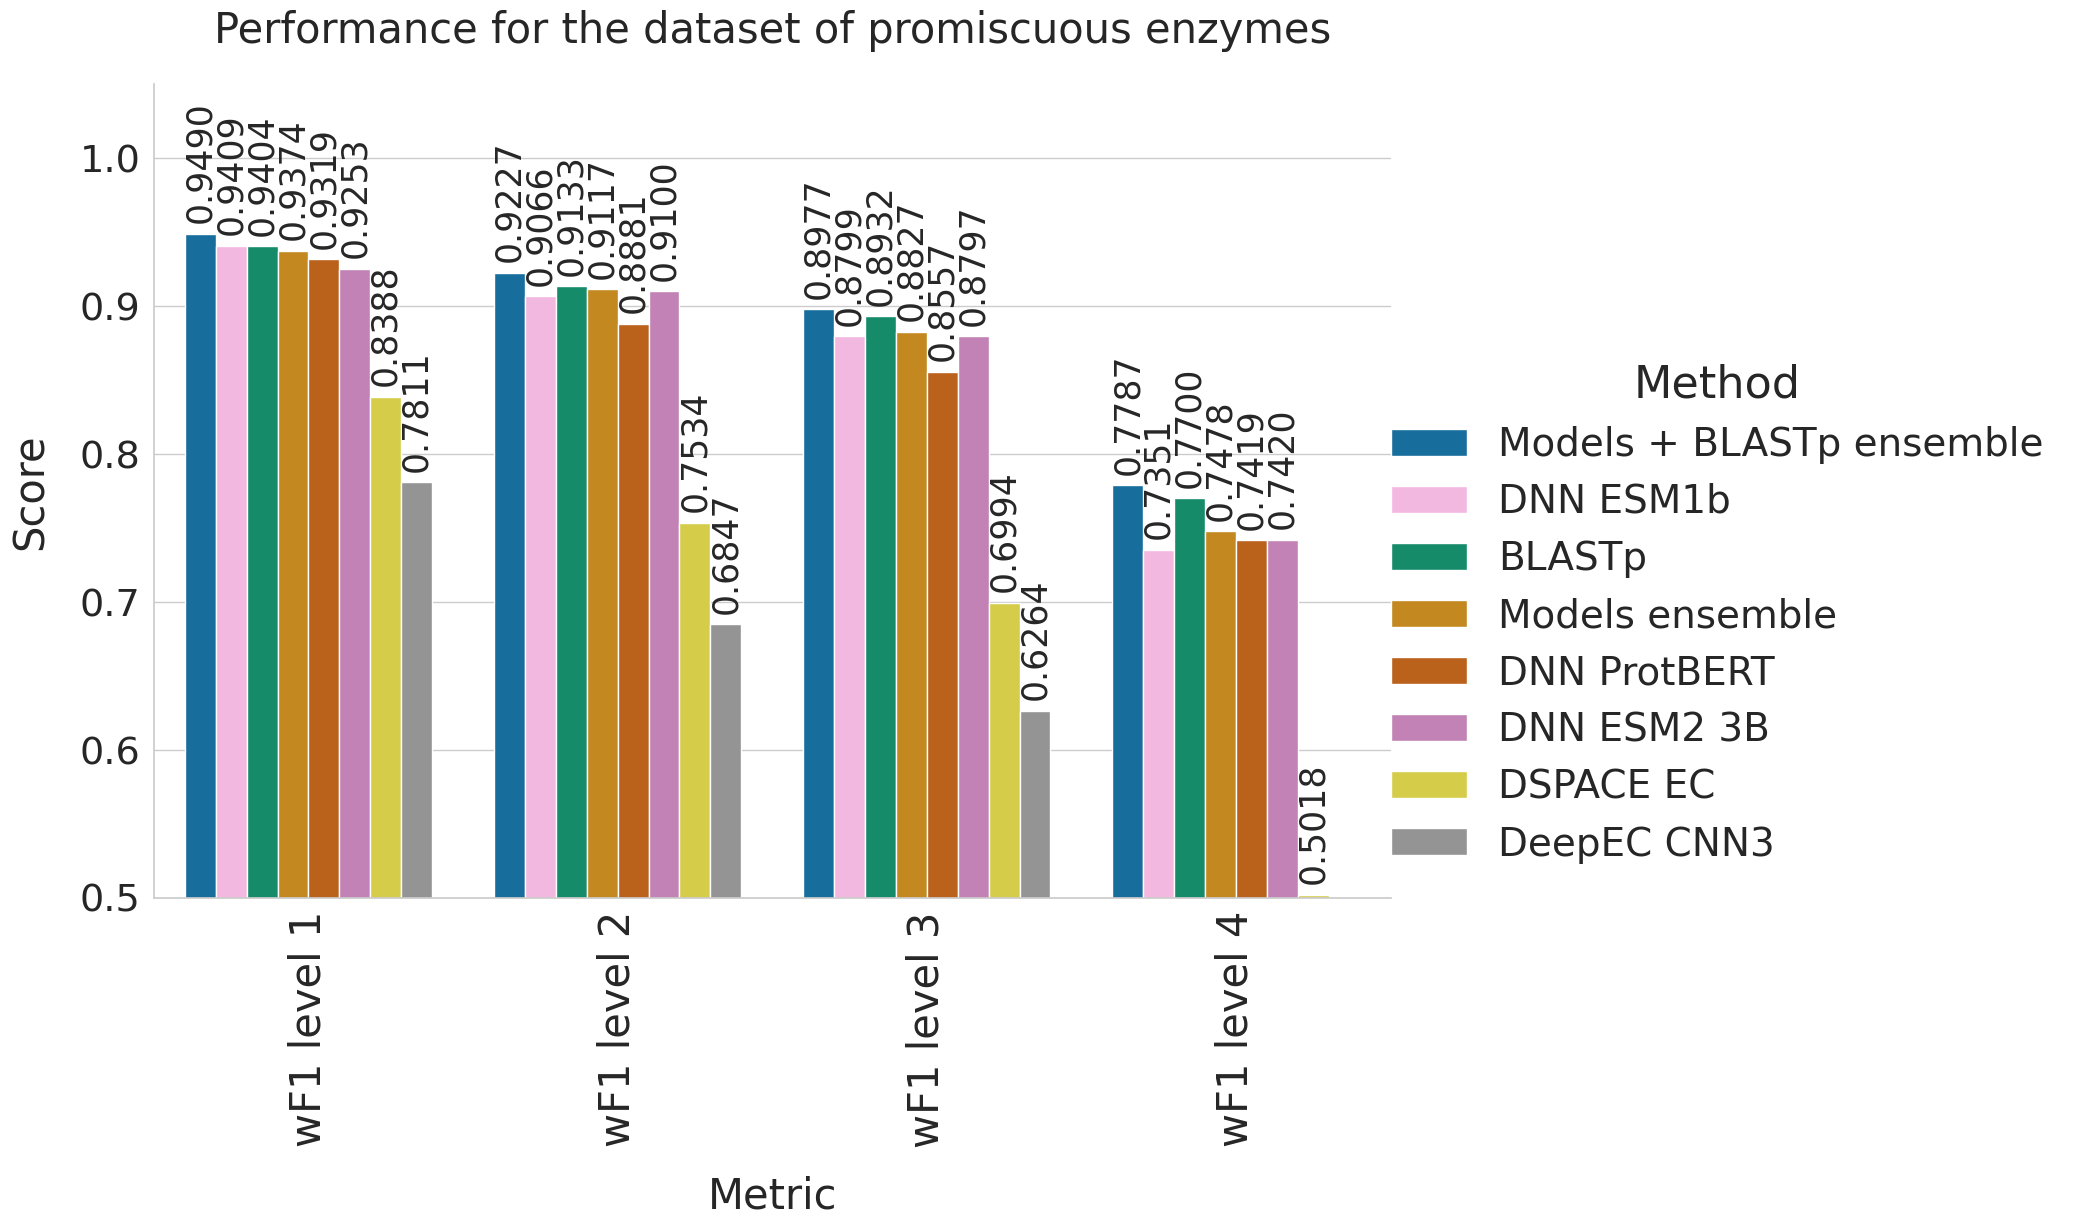

In [4]:
# create a bar plot of the f1 scores, precision and recall all in different plots

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True

models_performance = pd.read_csv("models_performance_promiscuous.csv", index_col=0)
models_performance_ = models_performance.iloc[:, 1:5]
models_performance_["model"] = models_performance["model"]
# models_performance_ = models_performance.reset_index()
# models_performance_ = models_performance.rename(columns={"index": "model"})
models_performance_ = models_performance_.melt(id_vars=["model"], var_name="metric", value_name="score")
models_performance_ = models_performance_.sort_values(by=["metric","score"], ascending=[True, False])

plt.figure(figsize=(10, 8))
sns.set(rc={'figure.figsize':(10, 8)})
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
sns.set_palette("Set2")


g = sns.catplot(x="metric", y="score", hue="model", data=models_performance_, kind="bar", height=10, aspect=1.5, palette=color_map)

for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height() +  0.04), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=25,  # Adjust the fontsize here
                    rotation=90)

plt.title("Performance for the dataset of promiscuous enzymes", pad=30, fontsize=30)
plt.xlabel("Metric", labelpad=20, fontsize=30)
plt.ylabel("Score", labelpad=20, fontsize=30)


plt.setp(g.legend.get_texts(), fontsize='28') # for legend text
plt.setp(g.legend.get_title(), fontsize='32') 
g.legend.set_title("Method", prop = {'size':'32'})
g.set_xticklabels(rotation=90, fontsize=30)
g.set(ylim=(0.5, 1.05))
g.savefig("models_performance_promiscuous.png", bbox_inches='tight', dpi=400)